In [11]:
import numpy as np
import pandas as pd


# download dataframe
data = pd.read_csv('Bitcoin_2014-2022.csv')
log_returns = np.diff(np.log(data['Close']))
data.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2014-09-17,465.864014,468.174011,452.421997,457.334015,457.334015,21056800
1,2014-09-18,456.859985,456.859985,413.104004,424.440002,424.440002,34483200
2,2014-09-19,424.102997,427.834991,384.532013,394.795990,394.795990,37919700
3,2014-09-20,394.673004,423.295990,389.882996,408.903992,408.903992,36863600
4,2014-09-21,408.084991,412.425995,393.181000,398.821014,398.821014,26580100


Text(0.5, 0.98, 'Time series of Bitcoin')

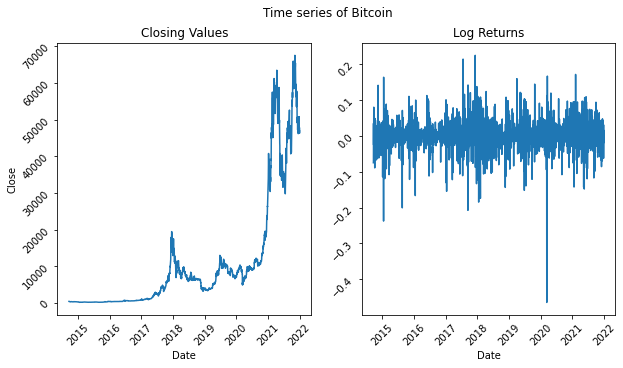

In [19]:
import matplotlib.pyplot as plt
import seaborn as sns

fig, axs = plt.subplots(1,2, figsize=(10, 5), squeeze=True)
sns.lineplot(x=data.index, y='Close', data=data, ax=axs[0])
sns.lineplot(x=data.index[1:], y=log_returns, ax=axs[1])


axs[0].title.set_text('Closing Values')
axs[0].tick_params(labelrotation=45)

axs[1].title.set_text('Log Returns')
axs[1].tick_params(labelrotation=45)

fig.suptitle('Time series of Bitcoin')

c:\users\g_man\onedrive\depaul\monte carlo algorithms\assignments\cryptocurrency monte carlo simulation\venv\lib\site-packages\statsmodels\graphics\tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


Text(0.5, 0.98, 'AutoCorrelation Plots')

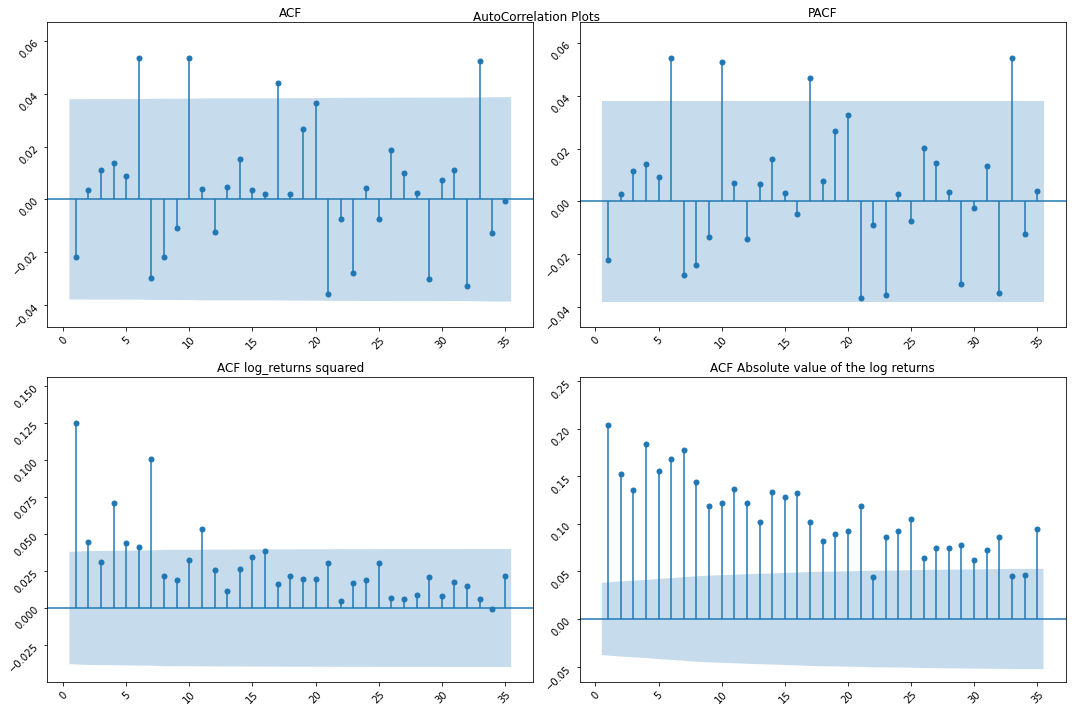

In [21]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

fig, axs = plt.subplots(2,2, figsize=(15, 10), squeeze=True)
plot_acf(log_returns, ax=axs[0,0], zero=False, auto_ylims=True)
plot_pacf(log_returns, ax=axs[0,1], zero=False, auto_ylims=True)
plot_acf(log_returns**2, ax=axs[1,0], zero=False, auto_ylims=True)
plot_acf(abs(log_returns), ax=axs[1,1], zero=False, auto_ylims=True)


axs[0,0].title.set_text('ACF')
axs[0,0].tick_params(labelrotation=45)

axs[0,1].title.set_text('PACF')
axs[0,1].tick_params(labelrotation=45)

axs[1,0].title.set_text('ACF log_returns squared')
axs[1,0].tick_params(labelrotation=45)

axs[1,1].title.set_text('ACF Absolute value of the log returns')
axs[1,1].tick_params(labelrotation=45)
fig.tight_layout()
fig.suptitle('AutoCorrelation Plots')

In [39]:
import pmdarima as arima
from arch import arch_model

n_split = 10
train, test = log_returns[:-n_split], log_returns[-n_split:]

arima_model_fitted = arima.auto_arima(train)
arima_residuals = arima_model_fitted.arima_res_.resid

model = arch_model(arima_residuals, vol='GARCH', p=1, q=1)
fitted_model = model.fit()
fitted_model.summary()

Iteration:      1,   Func. Count:      6,   Neg. LLF: 20189147.938356146
Iteration:      2,   Func. Count:     18,   Neg. LLF: 3597296292603458.0
Iteration:      3,   Func. Count:     29,   Neg. LLF: -5025.5902558328435
Optimization terminated successfully    (Exit mode 0)
            Current function value: -5025.590234261956
            Iterations: 7
            Function evaluations: 29
            Gradient evaluations: 3


c:\users\g_man\onedrive\depaul\monte carlo algorithms\assignments\cryptocurrency monte carlo simulation\venv\lib\site-packages\arch\univariate\base.py:309: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.001545. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(


<class 'statsmodels.iolib.summary.Summary'>
"""
                     Constant Mean - GARCH Model Results                      
==============================================================================
Dep. Variable:                      y   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:                  0.000
Vol Model:                      GARCH   Log-Likelihood:                5025.59
Distribution:                  Normal   AIC:                          -10043.2
Method:            Maximum Likelihood   BIC:                          -10019.6
                                        No. Observations:                 2653
Date:                Tue, Feb 08 2022   Df Residuals:                     2652
Time:                        14:04:38   Df Model:                            1
                                  Mean Model                                 
=============================================================================
                 coef    std err          t      P>|t|       95.0% Conf. Int.
-----------------------------------------------------------------------------
mu         3.3293e-04  7.981e-04      0.417      0.677 [-1.231e-03,1.897e-03]
                              Volatility Model                              
============================================================================
                 coef    std err          t      P>|t|      95.0% Conf. Int.
----------------------------------------------------------------------------
omega      3.0902e-05  3.762e-06      8.214  2.145e-16 [2.353e-05,3.828e-05]
alpha[1]       0.1000  2.896e-02      3.453  5.545e-04   [4.324e-02,  0.157]
beta[1]        0.8800  2.368e-02     37.166 2.401e-302     [  0.834,  0.926]
============================================================================

Covariance estimator: robust
"""

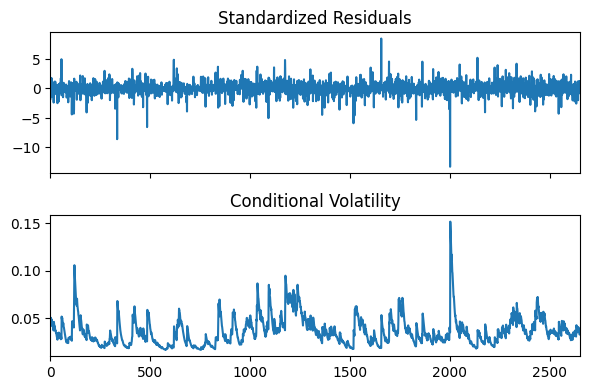

In [40]:
results = fitted_model.plot()
results.tight_layout()
results.set_dpi(100)

In [1]:
# Not sure why I'm not getting anything other than zeros
forecast = fitted_model.forecast(horizon=n_split,reindex=False)
forecast.residual_variance.plot()


NameError: name 'fitted_model' is not defined